In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opendatasets

In [9]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jangedoo/utkface-new")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chathui3628
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new


100%|██████████| 331M/331M [00:00<00:00, 617MB/s]


In [10]:
# IMPORTS
import os, random
import numpy as np
import tensorflow as tf
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [ ]:
# CONFIG
# ================================================================
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100
LR = 3e-4

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

dataset_path = "/content/utkface-new/UTKFace"

In [ ]:
# AGE GROUPING
# ================================================================
def age_to_group(age):
    if age <= 2:
        return 0
    elif age <= 6:
        return 1
    elif age <= 13:
        return 2
    elif age <= 20:
        return 3
    elif age <= 32:
        return 4
    elif age <= 43:
        return 5
    elif age <= 53:
        return 6
    else:
        return 7

AGE_LABELS = [
    "Baby(0-2)", "Toddler(3-6)", "Child(7-13)", "Teen(14-20)",
    "Young Adult(21-32)", "Adult(33-43)", "Middle Age(44-53)", "Senior(54+)"
]





In [13]:
# LOAD DATA
# ================================================================
files, ages, genders = [], [], []

for f in os.listdir(dataset_path):
    if f.lower().endswith(".jpg"):
        try:
            age, gender = int(f.split("_")[0]), int(f.split("_")[1])
            if 0 <= age <= 116:
                files.append(os.path.join(dataset_path, f))
                ages.append(age_to_group(age))
                genders.append(gender)
        except:
            pass

files = np.array(files)
ages = np.array(ages)
genders = np.array(genders)

print("Total images:", len(files))

Total images: 23708


In [15]:
# SPLIT
# ================================================================
X_train, X_temp, y_age_train, y_age_temp, y_gen_train, y_gen_temp = train_test_split(
    files, ages, genders, test_size=0.2, stratify=ages, random_state=SEED)

X_val, X_test, y_age_val, y_age_test, y_gen_val, y_gen_test = train_test_split(
    X_temp, y_age_temp, y_gen_temp, test_size=0.5, stratify=y_age_temp, random_state=SEED)

total = len(files)

train_count = len(X_train)
val_count   = len(X_val)
test_count  = len(X_test)

print("\n================ DATASET SPLIT SUMMARY ================\n")

print(f"Total Images      : {total}")
print(f"Train Set         : {train_count} images ({train_count/total*100:.2f}%)")
print(f"Validation Set    : {val_count} images ({val_count/total*100:.2f}%)")
print(f"Test Set          : {test_count} images ({test_count/total*100:.2f}%)")

print("\n=======================================================\n")




================ DATASET SPLIT SUMMARY ================

Total Images      : 23708
Train Set         : 18966 images (80.00%)
Validation Set    : 2371 images (10.00%)
Test Set          : 2371 images (10.00%)




In [21]:
y_age_train_oh = tf.keras.utils.to_categorical(y_age_train, NUM_AGE_CLASSES)
y_age_val_oh   = tf.keras.utils.to_categorical(y_age_val, NUM_AGE_CLASSES)
y_age_test_oh  = tf.keras.utils.to_categorical(y_age_test, NUM_AGE_CLASSES)

In [25]:
# PREPROCESSING (KEY PART)
# ================================================================
def parse_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    # Contrast enhancement
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.adjust_contrast(img, 1.6)
    img = tf.image.grayscale_to_rgb(img)

    return preprocess_input(img)

def make_dataset(paths, ages, genders, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, genders, ages))

    if shuffle:
        ds = ds.shuffle(len(paths))

    def load(p, g, a):
        return parse_image(p), {"gender": g, "age": a}

    ds = ds.map(load, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(X_train, y_age_train_oh, y_gen_train, shuffle=True)
val_ds   = make_dataset(X_val, y_age_val_oh, y_gen_val)
test_ds  = make_dataset(X_test, y_age_test_oh, y_gen_test)



In [26]:
# CLASS WEIGHTS (AGE)
# ================================================================
cw = compute_class_weight("balanced", classes=np.unique(y_age_train), y=y_age_train)
age_weights = dict(enumerate(cw))

In [28]:
# MODEL
# ================================================================
base = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in base.layers[:80]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation="swish")(x)
x = Dropout(0.3)(x)

gender_out = Dense(1, activation="sigmoid", name="gender")(x)
age_out = Dense(6, activation="softmax", name="age")(x)

model = Model(base.input, [gender_out, age_out])

model.compile(
    optimizer=Adam(LR),
    loss={
        "gender": tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        "age": tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    },
    loss_weights={"gender": 0.3, "age": 0.7},
    metrics={"gender": "accuracy", "age": "accuracy"}
)


model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        648 │ rescaling_4[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 112, 112,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 20,661,095 (78.82 MB)

 Trainable params: 19,476,591 (74.30 MB)

 Non-trainable params: 1,184,504 (4.52 MB)

In [35]:
# CALLBACKS
# ================================================================
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    EarlyStopping(monitor="val_age_accuracy",patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_age_accuracy", patience=3, factor=0.5),
    ModelCheckpoint(f"/content/drive/MyDrive/UTK_best_{ts}.h5",
                    monitor="val_age_accuracy", save_best_only=True)
]

In [36]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_age_gender_model.h5",
        monitor="val_age_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_age_accuracy",
        mode="max",
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]


In [37]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/100
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - age_accuracy: 0.8099 - age_loss: 0.7988 - gender_accuracy: 0.9265 - gender_loss: 0.2663 - loss: 0.6390
Epoch 1: val_age_accuracy improved from -inf to 0.75496, saving model to best_age_gender_model.h5


1186/1186 ━━━━━━━━━━━━━━━━━━━━ 178s 150ms/step - age_accuracy: 0.8099 - age_loss: 0.7988 - gender_accuracy: 0.9265 - gender_loss: 0.2663 - loss: 0.6390 - val_age_accuracy: 0.7550 - val_age_loss: 0.8947 - val_gender_accuracy: 0.9228 - val_gender_loss: 0.2586 - val_loss: 0.7054 - learning_rate: 3.0000e-04
Epoch 2/100
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - age_accuracy: 0.8585 - age_loss: 0.7142 - gender_accuracy: 0.9381 - gender_loss: 0.2462 - loss: 0.5738
Epoch 2: val_age_accuracy improved from 0.75496 to 0.76044, saving model to best_age_gender_model.h5


1186/1186 ━━━━━━━━━━━━━━━━━━━━ 183s 154ms/step - age_accuracy: 0.8585 - age_loss: 0.7142 - gender_accuracy: 0.9381 - gender_loss: 0.2462 - loss: 0.5738 - val_age_accuracy: 0.7604 - val_age_loss: 0.9091 - val_gender_accuracy: 0.9296 - val_gender_loss: 0.2553 - val_loss: 0.7146 - learning_rate: 3.0000e-04
Epoch 3/100
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - age_accuracy: 0.9027 - age_loss: 0.6335 - gender_accuracy: 0.9503 - gender_loss: 0.2255 - loss: 0.5111
Epoch 3: val_age_accuracy did not improve from 0.76044
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 175s 147ms/step - age_accuracy: 0.9027 - age_loss: 0.6335 - gender_accuracy: 0.9503 - gender_loss: 0.2255 - loss: 0.5111 - val_age_accuracy: 0.7528 - val_age_loss: 0.9764 - val_gender_accuracy: 0.9279 - val_gender_loss: 0.2599 - val_loss: 0.7625 - learning_rate: 3.0000e-04
Epoch 4/100
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - age_accuracy: 0.9309 - age_loss: 0.5821 - gender_accuracy: 0.9616 - gender_loss: 0.2049 - loss: 0.4690
Epoch 4: va

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 173s 146ms/step - age_accuracy: 0.9761 - age_loss: 0.4863 - gender_accuracy: 0.9840 - gender_loss: 0.1592 - loss: 0.3882 - val_age_accuracy: 0.7613 - val_age_loss: 1.0178 - val_gender_accuracy: 0.9350 - val_gender_loss: 0.2725 - val_loss: 0.7967 - learning_rate: 9.0000e-05
Epoch 8/100
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - age_accuracy: 0.9899 - age_loss: 0.4552 - gender_accuracy: 0.9926 - gender_loss: 0.1421 - loss: 0.3613
Epoch 8: val_age_accuracy did not improve from 0.76128
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 200s 144ms/step - age_accuracy: 0.9899 - age_loss: 0.4553 - gender_accuracy: 0.9926 - gender_loss: 0.1421 - loss: 0.3613 - val_age_accuracy: 0.7583 - val_age_loss: 1.0579 - val_gender_accuracy: 0.9329 - val_gender_loss: 0.2747 - val_loss: 0.8255 - learning_rate: 9.0000e-05
Epoch 9/100
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - age_accuracy: 0.9916 - age_loss: 0.4498 - gender_accuracy: 0.9940 - gender_loss: 0.1371 - loss: 0.3560
Epoch 9: va

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 173s 146ms/step - age_accuracy: 0.9903 - age_loss: 0.4502 - gender_accuracy: 0.9926 - gender_loss: 0.1391 - loss: 0.3569 - val_age_accuracy: 0.7663 - val_age_loss: 1.0438 - val_gender_accuracy: 0.9342 - val_gender_loss: 0.2759 - val_loss: 0.8159 - learning_rate: 9.0000e-05
Epoch 11/100
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - age_accuracy: 0.9923 - age_loss: 0.4453 - gender_accuracy: 0.9943 - gender_loss: 0.1342 - loss: 0.3519
Epoch 11: val_age_accuracy did not improve from 0.76634

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 174s 147ms/step - age_accuracy: 0.9923 - age_loss: 0.4453 - gender_accuracy: 0.9943 - gender_loss: 0.1342 - loss: 0.3519 - val_age_accuracy: 0.7647 - val_age_loss: 1.0667 - val_gender_accuracy: 0.9346 - val_gender_loss: 0.2755 - val_loss: 0.8320 - learning_rate: 9.0000e-05
Epoch 12/100
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - age_accuracy: 0.9935 - age_loss: 

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 178s 150ms/step - age_accuracy: 0.9945 - age_loss: 0.4364 - gender_accuracy: 0.9976 - gender_loss: 0.1252 - loss: 0.3430 - val_age_accuracy: 0.7680 - val_age_loss: 1.0854 - val_gender_accuracy: 0.9355 - val_gender_loss: 0.2778 - val_loss: 0.8460 - learning_rate: 8.1000e-06
Epoch 18/100
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - age_accuracy: 0.9961 - age_loss: 0.4334 - gender_accuracy: 0.9984 - gender_loss: 0.1239 - loss: 0.3406
Epoch 18: val_age_accuracy did not improve from 0.76803
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 170s 144ms/step - age_accuracy: 0.9961 - age_loss: 0.4334 - gender_accuracy: 0.9984 - gender_loss: 0.1239 - loss: 0.3406 - val_age_accuracy: 0.7659 - val_age_loss: 1.0901 - val_gender_accuracy: 0.9376 - val_gender_loss: 0.2791 - val_loss: 0.8496 - learning_rate: 8.1000e-06
Epoch 19/100
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - age_accuracy: 0.9960 - age_loss: 0.4321 - gender_accuracy: 0.9978 - gender_loss: 0.1245 - loss: 0.3399
Epoch 19

In [ ]:
model.save("/content/drive/MyDrive/UTKFace_Final_Models/final_model_{timestamp}.h5")
print("model saved successfully")

model saved successfully


In [41]:
# FINAL EVALUATION
# ================================================================
test_res  = model.evaluate(test_ds, verbose=0, return_dict=True)

print("\n=========== FINAL ACCURACY ===========")
print(f"TEST   - Gender: {test_res['gender_accuracy']*100:.2f}% | Age: {test_res['age_accuracy']*100:.2f}%")
print("====================================")


=========== FINAL ACCURACY ===========
TEST   - Gender: 92.62% | Age: 77.06%


In [40]:
# FINAL EVALUATION
# ================================================================
train_res = model.evaluate(train_ds, verbose=0, return_dict=True)
test_res  = model.evaluate(test_ds, verbose=0, return_dict=True)

print("\n=========== FINAL ACCURACY ===========")
print(f"TRAIN  - Gender: {train_res['gender_accuracy']*100:.2f}% | Age: {train_res['age_accuracy']*100:.2f}%")
print(f"TEST   - Gender: {test_res['gender_accuracy']*100:.2f}% | Age: {test_res['age_accuracy']*100:.2f}%")
print("====================================")


=========== FINAL ACCURACY ===========
TRAIN  - Gender: 99.87% | Age: 99.69%
TEST   - Gender: 92.62% | Age: 77.06%


In [39]:
# FINAL EVALUATION
# ================================================================
train_res = model.evaluate(train_ds, verbose=0, return_dict=True)
val_res   = model.evaluate(val_ds, verbose=0, return_dict=True)
test_res  = model.evaluate(test_ds, verbose=0, return_dict=True)

print("\n=========== FINAL ACCURACY ===========")
print(f"TRAIN  - Gender: {train_res['gender_accuracy']*100:.2f}% | Age: {train_res['age_accuracy']*100:.2f}%")
print(f"VAL    - Gender: {val_res['gender_accuracy']*100:.2f}% | Age: {val_res['age_accuracy']*100:.2f}%")
print(f"TEST   - Gender: {test_res['gender_accuracy']*100:.2f}% | Age: {test_res['age_accuracy']*100:.2f}%")
print("====================================")


=========== FINAL ACCURACY ===========
TRAIN  - Gender: 99.87% | Age: 99.69%
VAL    - Gender: 93.55% | Age: 76.80%
TEST   - Gender: 92.62% | Age: 77.06%


In [42]:
IMG_SIZE = 224

def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    # Contrast enhancement (same as training)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.adjust_contrast(img, 1.6)
    img = tf.image.grayscale_to_rgb(img)

    img = preprocess_input(img)
    return tf.expand_dims(img, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


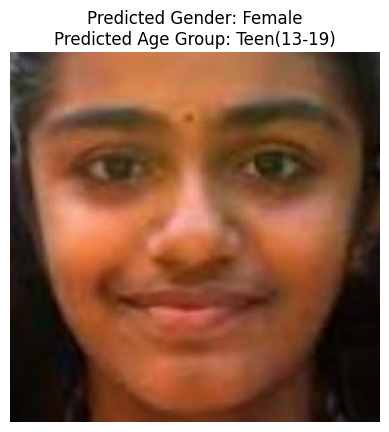

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Labels
GENDER_LABELS = {0: "Male", 1: "Female"}
AGE_LABELS = [
    "Baby(0-2)", "Toddler(3-6)", "Child(7-13)", "Teen(14-20)",
    "Young Adult(21-32)", "Adult(33-43)", "Middle Age(44-53)", "Senior(54+)"
]


# Image path
IMAGE_PATH = "/content/utkface-new/UTKFace/15_1_3_20170104221722328.jpg.chip.jpg"

# Load and preprocess
def preprocess_image_for_display(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img_resized = tf.image.resize(img, (224, 224))
    img_preprocessed = preprocess_input(img_resized)
    return img_preprocessed, img  # Return original for display

img_input, img_display = preprocess_image_for_display(IMAGE_PATH)
img_input = tf.expand_dims(img_input, axis=0)  # Add batch dimension

# Predict
gender_pred, age_pred = model.predict(img_input)

pred_gender = GENDER_LABELS[int(gender_pred[0][0] > 0.5)]
pred_age = AGE_LABELS[int(tf.argmax(age_pred[0]))]

# Display
plt.imshow(img_display.numpy().astype("uint8"))
plt.axis("off")
plt.title(f"Predicted Gender: {pred_gender}\nPredicted Age Group: {pred_age}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


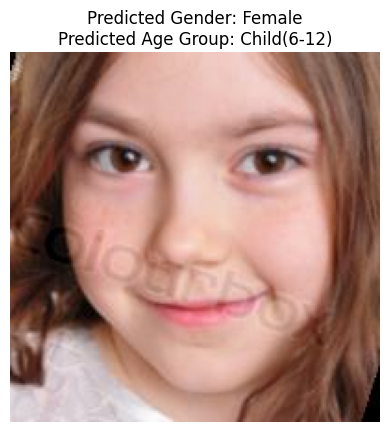

In [45]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Labels
GENDER_LABELS = {0: "Male", 1: "Female"}
AGE_LABELS = [
    "Baby(0-5)", "Child(6-12)", "Teen(13-19)",
    "Young Adult(20-35)", "Middle Age(36-55)", "Senior(56+)"
]

# Image path
IMAGE_PATH = "/content/utkface-new/UTKFace/10_1_0_20170109205134282.jpg.chip.jpg"

# Load and preprocess
def preprocess_image_for_display(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img_resized = tf.image.resize(img, (224, 224))
    img_preprocessed = preprocess_input(img_resized)
    return img_preprocessed, img  # Return original for display

img_input, img_display = preprocess_image_for_display(IMAGE_PATH)
img_input = tf.expand_dims(img_input, axis=0)  # Add batch dimension

# Predict
gender_pred, age_pred = model.predict(img_input)

pred_gender = GENDER_LABELS[int(gender_pred[0][0] > 0.5)]
pred_age = AGE_LABELS[int(tf.argmax(age_pred[0]))]

# Display
plt.imshow(img_display.numpy().astype("uint8"))
plt.axis("off")
plt.title(f"Predicted Gender: {pred_gender}\nPredicted Age Group: {pred_age}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


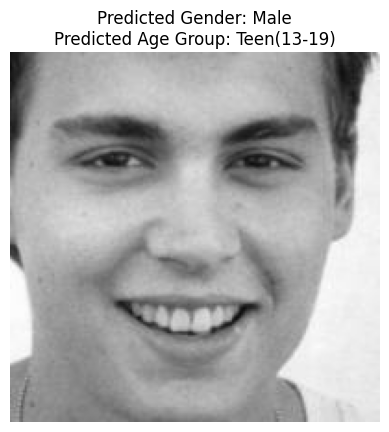

In [46]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Labels
GENDER_LABELS = {0: "Male", 1: "Female"}
AGE_LABELS = [
    "Baby(0-5)", "Child(6-12)", "Teen(13-19)",
    "Young Adult(20-35)", "Middle Age(36-55)", "Senior(56+)"
]

# Image path
IMAGE_PATH = "/content/utkface-new/crop_part1/18_0_0_20170110231703804.jpg.chip.jpg"

# Load and preprocess
def preprocess_image_for_display(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img_resized = tf.image.resize(img, (224, 224))
    img_preprocessed = preprocess_input(img_resized)
    return img_preprocessed, img  # Return original for display

img_input, img_display = preprocess_image_for_display(IMAGE_PATH)
img_input = tf.expand_dims(img_input, axis=0)  # Add batch dimension

# Predict
gender_pred, age_pred = model.predict(img_input)

pred_gender = GENDER_LABELS[int(gender_pred[0][0] > 0.5)]
pred_age = AGE_LABELS[int(tf.argmax(age_pred[0]))]

# Display
plt.imshow(img_display.numpy().astype("uint8"))
plt.axis("off")
plt.title(f"Predicted Gender: {pred_gender}\nPredicted Age Group: {pred_age}")
plt.show()
